#### ***Objetivo***

Este trabalho tem como objetivo desenvolver e avaliar um **sistema de recomendação de filmes** utilizando o dataset **MovieLens (ml-latest-small)**.  
Serão aplicadas técnicas de **filtragem colaborativa** e **filtragem baseada em conteúdo**, explorando a possibilidade de combinar abordagens em um modelo híbrido para prever avaliações de usuários e gerar recomendações personalizadas.

O problema central a ser tratado é a **dificuldade dos usuários em escolher conteúdos relevantes diante de grandes catálogos digitais**, realidade que afeta diretamente a experiência em plataformas de streaming e outros serviços baseados em mídia. O MovieLens foi escolhido por sua ampla utilização acadêmica, riqueza de informações e adequação para experimentação prática.

A pesquisa busca responder à seguinte questão:  
    *É possível antecipar os gostos cinematográficos dos usuários e surpreendê-los com recomendações relevantes utilizando apenas suas avaliações e tags, combinando técnicas de filtragem colaborativa, baseada em conteúdo e modelos híbridos?*

Do ponto de vista prático, o projeto contribui para:  
- **Usuários finais**: oferecer sugestões mais personalizadas, reduzindo a sobrecarga de escolha.  
- **Profissionais de ciência de dados**: aplicar técnicas de machine learning em um contexto realista e replicável.  
- **Equipes de produto**: compreender como algoritmos de recomendação podem influenciar métricas de engajamento, retenção e satisfação.  

Assim, o estudo alia **conhecimento teórico** e **aplicação prática**, aproximando a pesquisa acadêmica de desafios concretos enfrentados por plataformas digitais de entretenimento e comércio eletrônico.

#### ***Importação de bibliotecas e carregamento dos datasets***

Nesta primeira etapa, foram importadas as bibliotecas necessárias para manipulação e análise dos dados:

- **pandas**: manipulação de tabelas (DataFrames).  
- **numpy**: suporte para cálculos numéricos e estatísticos.  
- **matplotlib.pyplot**: geração de gráficos.  
- **os** e **re**: manipulação de arquivos e expressões regulares.  
- **json**: suporte para exportações/estruturas em formato JSON.

In [1]:
import pandas as pd
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

#### ***Foram carregados os quatro arquivos CSV disponibilizados pelo **MovieLens (ml-latest-small)**, armazenados no diretório `archive/`:***

- `movies.csv` → contém informações dos filmes (título, ano e gêneros).  
- `ratings.csv` → avaliações atribuídas pelos usuários.  
- `tags.csv` → marcações (tags) aplicadas pelos usuários aos filmes.  
- `links.csv` → identificadores externos para bases como IMDb e TMDb.

In [2]:
# Caminho da pasta com os CSVs
data_dir = "data"

movies = pd.read_csv(os.path.join(data_dir, "movies.csv"), sep=',')
ratings = pd.read_csv(os.path.join(data_dir, "ratings.csv"), sep=',')
tags = pd.read_csv(os.path.join(data_dir, "tags.csv"), sep=',')
links = pd.read_csv(os.path.join(data_dir, "links.csv"), sep=',')

print("Arquivos carregados com sucesso!")


Arquivos carregados com sucesso!


## ***Trabalhando com movies.csv***

#### ***Visão inicial do `movies` (amostra do topo e do final)***

Antes de qualquer transformação, olhei as **primeiras** e as **últimas** linhas da tabela `movies`.  
Essa passada de olho ajuda a entender rapidamente o “jeito” dos dados e se está tudo coerente.

**O que aparece aqui:**
- `movieId`: um identificador numérico único de cada filme (é a nossa chave para juntar com outras tabelas).
- `title`: o título como veio no dataset, geralmente com o ano entre parênteses (ex.: `Toy Story (1995)`).
- `genres`: os gêneros do filme, separados por `|` (ex.: `Adventure|Animation|Children|Comedy|Fantasy`).

**Por que isso importa:**
- O `movieId` é a coluna que vamos usar em todos os *merges* (com `ratings`, `tags` e `links`).
- O `title` vai passar por uma limpeza simples para padronizar o texto e separar o **ano**.
- A coluna `genres` será transformada mais adiante em **colunas binárias** (one-hot) para apoiar a recomendação baseada em conteúdo.

**Primeiras impressões:**
- Os títulos parecem seguir o padrão “Nome do filme (ANO)”, o que facilita extrair o ano.
- Os gêneros vêm concatenados por `|`, então já sabemos como quebrar e codificar.
- Ver o topo e o final do arquivo dá confiança de que o carregamento foi correto e sem truncamentos.

> Resumo: a estrutura está limpa e direta, bem adequada para as etapas de padronização que virão (título, ano e gêneros).


In [3]:
display('Visualizando o topo dos dados:', movies.head(), 'Visualizando o final dos dados:', movies.tail())

'Visualizando o topo dos dados:'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Visualizando o final dos dados:'

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


#### ***Estrutura e dimensionalidade do dataset `movies`***

Com o comando `movies.info()`, verifiquei a estrutura da tabela e a qualidade das colunas. O resultado mostra:

- **Total de registros**: 9.742 linhas.  
- **Colunas**: 3 (`movieId`, `title`, `genres`).  
- **Tipos de dados**:
  - `movieId` → inteiro (`int64`)
  - `title` → texto (`object`)
  - `genres` → texto (`object`)
- **Valores nulos**: não existem (`Non-Null Count` é igual ao total de linhas em todas as colunas).  

Em seguida, comparei a quantidade de **IDs únicos** com o número total de linhas:

- **IDs únicos**: 9.742  
- **Total de linhas**: 9.742  

Isso confirma que **cada `movieId` aparece apenas uma vez**, ou seja, não há duplicação de filmes no dataset. Esse é um ponto muito importante, porque garante que podemos usar `movieId` como **chave primária** para juntar de forma segura com as tabelas `ratings`, `tags` e `links`.

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
print(f"IDs únicos: {movies['movieId'].nunique()}")
print(f"Total de linhas: {len(movies)}")

IDs únicos: 9742
Total de linhas: 9742


#### ***Extração do ano de lançamento***

Como o campo `title` traz o nome do filme junto com o ano entre parênteses (ex.: *Toy Story (1995)*), foi necessário separar essas duas informações.  
Para isso, utilizei uma **expressão regular (regex)** que captura os 4 dígitos finais entre parênteses, criando a coluna `year`.

Agora, a tabela `movies` conta com uma nova coluna:
- `year` (novo campo, numérico extraído do título)  

**Por que fazer isso?**
- Ter o **ano em uma coluna separada** permite análises ao longo do tempo (como número de filmes lançados por Ano).  
- Facilita filtros (ex.: “recomendar apenas filmes mais atuais”).  
- Mantém o título mais limpo, deixando apenas o nome do filme para exibição ao usuário.

Esse é um passo importante de **pré-processamento**, pois transforma dados textuais em variáveis estruturadas que podemos usar em análises estatísticas e em sistemas de recomendação.


In [6]:
# Separando título e ano
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


#### ***Limpeza e Padronização dos Títulos***

Os títulos originais dos filmes no dataset vinham acompanhados do ano de lançamento entre parênteses, além de apresentarem inconsistências de formatação, como diferenças no uso de maiúsculas e minúsculas ou presença de siglas e numerais em formatos variados. Essas inconsistências poderiam prejudicar futuras análises, já que títulos escritos de formas diferentes seriam interpretados como filmes distintos.

Para resolver esse problema, criamos a função **`normalize_title`**, que aplica uma série de transformações:

1. **Remoção do ano**  
   O ano entre parênteses no final do título foi retirado, pois essa informação já está armazenada em outra coluna (`year`).

2. **Padronização para *Title Case***  
   Cada palavra do título passa a começar com letra maiúscula, garantindo uniformidade.  
   Exemplos:  
   - *"toy story"* → **"Toy Story"**  
   - *"waiting to exhale"* → **"Waiting To Exhale"**

3. **Correção de numerais romanos**  
   Numerais romanos (II, III, IV, VI etc.) foram padronizados em caixa alta, evitando situações como *"Rocky ii"* ou *"Star Wars iv"*.

4. **Ajuste de siglas comuns**  
   Algumas siglas importantes, como **USA, UK, IMAX, 3D**, foram preservadas em caixa alta para manter a legibilidade.

5. **Remoção de espaços desnecessários**  
   Espaços duplicados ou no início/fim foram eliminados.

---

In [7]:
def normalize_title(title: str) -> str:
    if pd.isna(title):
        return title

    # Remove o ano (no final entre parênteses)
    title = re.sub(r"\s*\(\d{4}\)\s*$", "", title).strip()

    # Aplica Title Case
    title = title.title()

    # Corrige numerais romanos (II, III, IV, VI, VII, VIII, IX, X)
    roman_pattern = r"\b(I|Ii|Iii|Iv|Vi|Vii|Viii|Ix|X)\b"
    title = re.sub(roman_pattern, lambda m: m.group(1).upper(), title)

    # Corrige algumas siglas comuns
    siglas = ["USA", "UK", "IMAX", "3D", "II", "III", "IV", "VI", "VII", "VIII", "IX", "X"]
    for s in siglas:
        title = re.sub(rf"\b{s.title()}\b", s, title)

    # Remove espaços múltiplos (se houver)
    title = re.sub(r"\s+", " ", title).strip()

    return title

In [8]:
movies["title_clean"] = movies["title"].apply(normalize_title)

# Conferir alguns exemplos
movies[["title", "title_clean"]]


,title,title_clean
0,Toy Story (1995),Toy Story
1,Jumanji (1995),Jumanji
2,Grumpier Old Men (1995),Grumpier Old Men
3,Waiting to Exhale (1995),Waiting To Exhale
4,Father of the Bride Part II (1995),Father Of The Bride Part II
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Black Butler: Book Of The Atlantic
9738,No Game No Life: Zero (2017),No Game No Life: Zero
9739,Flint (2017),Flint
9740,Bungo Stray Dogs: Dead Apple (2018),Bungo Stray Dogs: Dead Apple


### 📌 Extração e Conversão do Ano de Lançamento

Realizamos a conversão dos valores para o tipo numérico (`Int64`), garantindo que o ano possa ser tratado de forma consistente em cálculos e estatísticas. Também foram tratados casos em que o ano não estava presente no título (nesse caso, o valor fica como *NaN*).

---

### ✅ Estatísticas Descritivas do Ano

O método `.describe()` gera estatísticas descritivas que ajudam a entender melhor a distribuição dos dados.  
No caso da coluna **`year`**, os resultados foram:

- **count (9729)** → Quantidade de registros não nulos (ou seja, quantos filmes possuem ano de lançamento identificado).  
- **mean (1994.6)** → Média dos anos, mostrando que em média os filmes foram lançados por volta de 1995.  
- **std (18.53)** → Desvio padrão, que mede a dispersão em relação à média. Aqui indica que, em geral, os anos de lançamento variam cerca de 18 anos para mais ou para menos em relação à média.  
- **min (1902)** → Ano mais antigo registrado na base (primeiros filmes catalogados).  
- **25% (1988)** → Primeiro quartil: 25% dos filmes foram lançados até 1988.  
- **50% (1999)** → Mediana: metade dos filmes foi lançada até 1999.  
- **75% (2008)** → Terceiro quartil: 75% dos filmes foram lançados até 2008.  
- **max (2018)** → Ano mais recente encontrado no dataset.

Esses números indicam que a base de dados cobre mais de um século de produções cinematográficas, indo desde filmes do início do século XX até lançamentos recentes de 2018.


In [9]:
# Converte year para numérico
movies["year"] = pd.to_numeric(movies["year"], errors="coerce").astype('Int64')

movies['year'].describe()

count         9729.0
mean     1994.613629
std        18.535219
min           1902.0
25%           1988.0
50%           1999.0
75%           2008.0
max           2018.0
Name: year, dtype: Float64

In [10]:
movies

,movieId,title,genres,year,title_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting To Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,Father Of The Bride Part II
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,Black Butler: Book Of The Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero
9739,193585,Flint (2017),Drama,2017,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple


#### ***Tratamento dos Gêneros dos Filmes***

A coluna **`genres`** contém os gêneros de cada filme, separados por `|`.  

Essa estrutura em forma de lista de strings não é ideal para análises e modelagem, pois dificulta cálculos e agrupamentos. Para resolver, seguimos os seguintes passos:

---

#### 1. Limpeza dos valores
- O valor `(no genres listed)` foi substituído por **NaN**, evitando que apareça como um gênero “falso”.
- Espaços vazios foram preenchidos com string vazia (`""`).

---

#### 2. Transformação para One-Hot Encoding
Aplicamos o método **`str.get_dummies(sep="|")`**, que cria uma nova coluna para cada gênero.  
Cada coluna indica, com valores **0 ou 1**, se o filme pertence ou não a esse gênero.

Exemplo simplificado:

| Título       | Gêneros Originais                  | Action | Adventure | Comedy |
|--------------|------------------------------------|--------|-----------|--------|
| Toy Story    | Adventure\|Animation\|Children\|Comedy |   0    |     1     |   1    |
| Jumanji      | Adventure\|Children\|Fantasy       |   0    |     1     |   0    |
| Heat         | Action\|Crime\|Thriller            |   1    |     0     |   0    |

---

#### 3. Junção ao DataFrame original
As colunas binárias foram adicionadas ao dataframe `movies`, gerando o dataframe final **`movies_ohe`**, com o seguinte formato:

- **9.742 linhas** (um registro por filme)  
- **24 colunas**, incluindo:
  - `movieId`, `title`, `genres`, `year`, `title_clean`
  - 19 colunas de gêneros (Action, Comedy, Drama, etc.)

---

### Benefícios do One-Hot Encoding
O **One-Hot Encoding (OHE)** é uma técnica usada para transformar variáveis categóricas em variáveis numéricas, de forma que possam ser entendidas por algoritmos de análise e modelos de Machine Learning.
- Permite **contar quantos filmes existem em cada gênero**.  
- Facilita análises estatísticas e construção de gráficos.  
- Torna os dados **compatíveis com algoritmos de Machine Learning**, que precisam de variáveis numéricas.  
- Permite criar **recomendações por similaridade de gênero**.

---

A tabela **`movies_ohe`** será a base final de filmes utilizada nas próximas análises e cruzamentos com as demais tabelas (`ratings`, `tags`, `links`).


In [11]:
# Evite "Unknown" no OHE: deixe vazio/NaN para não virar uma "categoria"
genres_clean = movies["genres"].replace("(no genres listed)", np.nan).fillna("")

In [12]:
# One-Hot com separador "|"
genres_ohe = genres_clean.str.get_dummies(sep="|")

In [13]:
genres_ohe

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Junta ao dataframe original
movies_ohe = pd.concat([movies, genres_ohe], axis=1)

In [15]:
print("Formato do OHE:", movies_ohe.shape)
display(movies_ohe)

Formato do OHE: (9742, 24)


,movieId,title,genres,year,title_clean,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting To Exhale,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,Father Of The Bride Part II,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,Black Butler: Book Of The Atlantic,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,2017,Flint,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Salva o resultado
movies_ohe.to_csv(r".\data\data_output\movies_processed.csv", index = False,encoding='utf-8-sig')

#### ***Versão "Explodida" por Gênero***

Até aqui, vimos que cada filme pode ter **vários gêneros ao mesmo tempo**, armazenados juntos na coluna `genres` e separados por `|`.  

Esse formato é útil para leitura humana, mas para algumas análises ele pode atrapalhar.  
Por exemplo: se quisermos **contar quantos filmes existem por gênero**, precisamos separar esses valores.

### O que foi feito
1. A coluna `genres` foi **separada** (`split`) em uma lista de gêneros.  
2. Em seguida, usamos a função `explode`, que cria **uma nova linha para cada gênero**.  

Isso significa que:  
- O filme **Toy Story (1995)**, que tinha 5 gêneros, agora aparece em **5 linhas diferentes**, cada uma com um gênero único.  


### Exemplo
Antes do `explode`:
| movieId | title           | genres                                   |
|---------|-----------------|------------------------------------------|
| 1       | Toy Story (1995)| Adventure\|Animation\|Children\|Comedy\|Fantasy |

Depois do `explode`:
| movieId | title           | genre     |
|---------|-----------------|-----------|
| 1       | Toy Story (1995)| Adventure |
| 1       | Toy Story (1995)| Animation |
| 1       | Toy Story (1995)| Children  |
| 1       | Toy Story (1995)| Comedy    |
| 1       | Toy Story (1995)| Fantasy   |


### Vantagens da versão "explodida"
- Permite fazer **contagens de filmes por gênero** facilmente.  
- Facilita a construção de **tabelas de frequência** (ex.: top 10 gêneros mais comuns).  
- Torna possível cruzar gêneros com outras variáveis, como ano de lançamento ou nota média.  


Em resumo: a versão "explodida" é como se pegássemos os filmes multigênero e os “abríssemos” em várias linhas, garantindo que cada linha tenha apenas **um único gênero**.


In [16]:
# Versão "explodida" por gênero (útil para contagens e tabelas)
movies_exploded = (
    movies.assign(genre = genres_clean.str.split("|"))
          .explode("genre")
)

# Remove linhas vazias (filmes sem gênero)
movies_exploded = movies_exploded[movies_exploded["genre"].notna() & (movies_exploded["genre"]!="")]

display(movies_exploded)
print("Linhas na versão explodida:", len(movies_exploded))

,movieId,title,genres,year,title_clean,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Animation
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Children
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Fantasy
...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero,Fantasy
9739,193585,Flint (2017),Drama,2017,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,Action
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,Animation


Linhas na versão explodida: 22050


#### ***Número de gêneros por filme***

Cada filme pode estar associado a múltiplos gêneros. Para quantificar essa informação, somamos os valores `1` de cada linha no DataFrame one-hot (`genres_ohe`), obtendo a coluna `n_genres`.

Essa coluna mostra quantos gêneros cada filme possui, permitindo análises como:

- A distribuição da quantidade de gêneros nos filmes.
- Identificação de filmes mais “multigênero”.
- Comparações com outras variáveis, como ano de lançamento ou popularidade.

Essa etapa é importante porque nem todos os filmes possuem apenas um gênero. Muitos títulos combinam **2 a 3 categorias**, e alguns chegam a 5 ou mais, o que pode influenciar nos resultados de recomendações.


In [17]:
n_genres = genres_ohe.sum(axis=1)
movies_ohe["n_genres"] = n_genres
movies_ohe[['genres','n_genres']]

,genres,n_genres
0,Adventure|Animation|Children|Comedy|Fantasy,5
1,Adventure|Children|Fantasy,3
2,Comedy|Romance,2
3,Comedy|Drama|Romance,3
4,Comedy,1
...,...,...
9737,Action|Animation|Comedy|Fantasy,4
9738,Animation|Comedy|Fantasy,3
9739,Drama,1
9740,Action|Animation,2


#### ***Análise da distribuição de gêneros no catálogo***

Nesta etapa, foi analisada a **estrutura do catálogo de filmes**, com foco na quantidade de gêneros associados a cada título e na frequência absoluta de cada gênero.


Esses números indicam que, em média, cada filme está associado a 2 gêneros. A maioria dos títulos possui entre 1 e 3 categorias, embora existam casos atípicos, como filmes sem gênero registrado (34) e um filme com 10 gêneros simultâneos.

In [18]:
print("Número total de filmes:", len(movies_ohe))
print("Número de gêneros distintos:", genres_ohe.shape[1])
print("Média de gêneros por filme:", n_genres.mean().round(3))
print("Mediana de gêneros por filme:", n_genres.median())
print("Moda de gêneros por filme:", n_genres.mode().iat[0])
print("Desvio padrão:", n_genres.std(ddof=1).round(3))
print("Mínimo / Máximo:", int(n_genres.min()), "/", int(n_genres.max()))

Número total de filmes: 9742
Número de gêneros distintos: 19
Média de gêneros por filme: 2.263
Mediana de gêneros por filme: 2.0
Moda de gêneros por filme: 2
Desvio padrão: 1.129
Mínimo / Máximo: 0 / 10


A tabela de frequência revela a seguinte distribuição:

- 34 filmes não possuem gênero atribuído.  
- A maior parte dos títulos possui **1 gênero (2.817 filmes)** ou **2 gêneros (3.218 filmes)**.  
- Um número considerável também possui **3 gêneros (2.338 filmes)**.  
- Casos com 5 ou mais gêneros são raros e podem ser considerados exceções.  

Isso confirma que os filmes, em geral, são classificados de forma simples, o que facilita a categorização e futuras análises.


In [19]:
# Tabela de distribuição (quantos filmes têm 0, 1, 2, ... gêneros)
dist = n_genres.value_counts().sort_index()
display(dist.to_frame(name="qtd_filmes"))

,qtd_filmes
0,34
1,2817
2,3218
3,2338
4,987
5,271
6,63
7,12
8,1
10,1


Esses resultados destacam que o catálogo é dominado por categorias amplas e populares, o que é consistente com a produção cinematográfica global.


In [20]:
# Gêneros mais frequentes (contagem)
genre_counts = genres_ohe.sum().sort_values(ascending=False)
topN = 15  # ajuste aqui se quiser mais/menos
display(genre_counts.head(topN).to_frame(name="qtd_filmes"))

,qtd_filmes
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


- Esta análise evidencia a **composição do catálogo de filmes**, e não o comportamento dos usuários.  
- O catálogo é predominantemente formado por filmes de **Drama** e **Comédia**, sugerindo que essas categorias possuem maior representatividade na base.  
- A grande maioria dos filmes possui entre **1 e 3 gêneros**, refletindo uma categorização relativamente simples.  
- Casos extremos (sem gênero ou com até 10 gêneros) podem ser tratados como **anomalias** em etapas futuras.  
- A análise de **consumo** (quais gêneros são mais assistidos ou bem avaliados) será possível apenas quando cruzarmos estes dados com o dataset de **ratings**.

#### ***Gráficos***
**Histograma do número de gêneros por filme**

O gráfico abaixo mostra a distribuição da quantidade de gêneros atribuídos a cada filme.  

#### Interpretação

- A maior concentração de filmes ocorre entre **1 e 3 gêneros**, confirmando o que já havíamos observado nas estatísticas descritivas.  
- O **pico da distribuição** está nos filmes com **2 gêneros**, que são mais comuns no catálogo.  
- Filmes com **4 ou mais gêneros** aparecem em menor quantidade, sendo considerados menos usuais.  
- Casos extremos, como filmes sem nenhum gênero registrado ou com até 10 categorias, aparecem como outliers e podem indicar inconsistências no cadastro.  

Esse gráfico ajuda a visualizar a tendência geral do catálogo: a maioria dos filmes é classificada de forma simples, em poucas categorias, o que facilita o agrupamento e análises posteriores. 

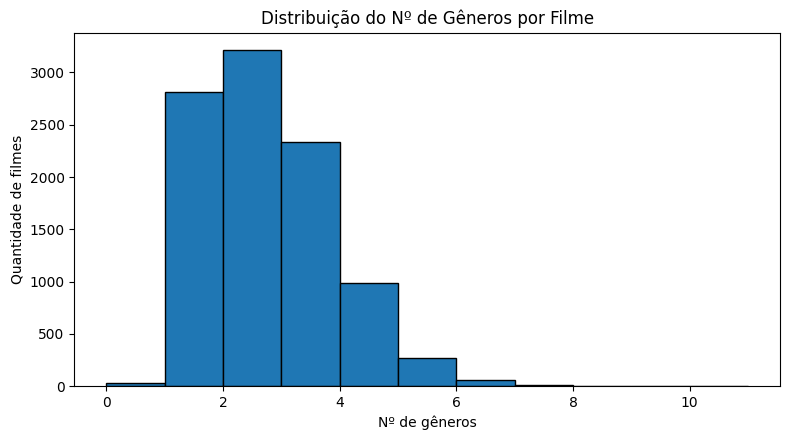

In [21]:
# Histograma do nº de gêneros por filme
plt.figure(figsize=(8,4.5))
plt.hist(movies_ohe["n_genres"], bins=range(int(movies_ohe["n_genres"].max())+2), edgecolor="black")
plt.title("Distribuição do Nº de Gêneros por Filme")
plt.xlabel("Nº de gêneros")
plt.ylabel("Quantidade de filmes")
plt.tight_layout()
plt.show()

**Gêneros mais frequentes no catálogo***

O gráfico abaixo mostra os 15 gêneros mais representados no dataset de filmes, considerando a frequência de títulos associados a cada categoria.


#### Interpretação

- Os gêneros **Drama** (4.361 filmes) e **Comédia** (3.756 filmes) se destacam fortemente, representando quase metade de todo o catálogo analisado.  
- Em seguida, aparecem gêneros como **Thriller** (1.894 filmes) e **Ação** (1.828 filmes), também com presença significativa.  
- Categorias como **Documentário**, **Mistério** e **Guerra** possuem representatividade bem menor, com menos de 600 filmes cada.  

Esses resultados indicam que o dataset é composto principalmente por gêneros amplos e populares, enquanto nichos mais específicos aparecem em menor escala.  
Essa informação é relevante para futuros sistemas de recomendação, já que a maior diversidade em gêneros dominantes pode facilitar sugestões personalizadas, mas também pode gerar **tendência de concentração** nas recomendações.


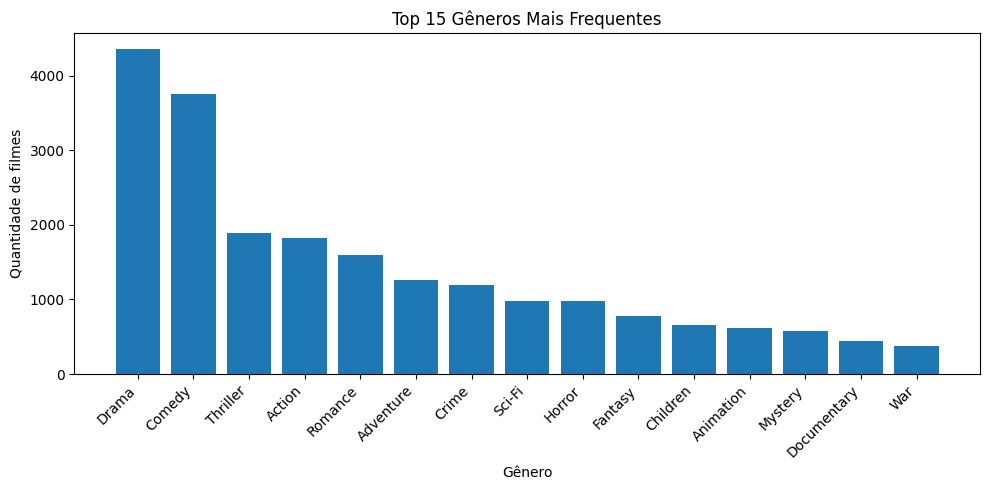

In [22]:
# Barras dos gêneros mais frequentes
top = genre_counts.head(topN)
plt.figure(figsize=(10,5))
plt.bar(top.index, top.values)
plt.title(f"Top {topN} Gêneros Mais Frequentes")
plt.xlabel("Gênero")
plt.ylabel("Quantidade de filmes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [23]:
# Resumo estatístico do nº de gêneros
summary = pd.Series({
    "n_filmes": len(movies_ohe),
    "n_generos_distintos": genres_ohe.shape[1],
    "media_generos_por_filme": n_genres.mean(),
    "mediana_generos_por_filme": n_genres.median(),
    "moda_generos_por_filme": n_genres.mode().iat[0],
    "desvio_padrao": n_genres.std(ddof=1),
    "min_generos": n_genres.min(),
    "max_generos": n_genres.max(),
}).round(3)

display(summary.to_frame(name="valor"))


,valor
n_filmes,9742.000
n_generos_distintos,19.000
media_generos_por_filme,2.263
mediana_generos_por_filme,2.000
moda_generos_por_filme,2.000
desvio_padrao,1.129
min_generos,0.000
max_generos,10.000


In [24]:
# Top gêneros em formato de tabela
top_generos_df = genre_counts.reset_index()
top_generos_df.columns = ["genero", "qtd_filmes"]
display(top_generos_df.head(topN))

,genero,qtd_filmes
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


***Evolução do Lançamento de Filmes por Ano***

***Quantidade de Filmes ao Longo do Tempo***

O gráfico de linha abaixo mostra a contagem de filmes lançados por ano, com base no dataset analisado:

- **1900–1950**: Produção ainda tímida, com poucos lançamentos por ano.  
- **1960–1980**: Crescimento gradual, indicando maior consolidação da indústria do cinema.  
- **1990–2010**: Forte aceleração, atingindo o pico com **mais de 300 filmes lançados em alguns anos**.  
- **2015 em diante**: Observa-se uma queda brusca, possivelmente relacionada a:
  - Incompletude do dataset nos anos mais recentes (nem todos os filmes cadastrados).  
  - Alterações na forma de registro e coleta dos dados.  

👉 **Interpretação:**  
O auge da produção cinematográfica se dá entre **1995 e 2010**, refletindo a globalização da indústria, expansão de estúdios e maior acesso a tecnologia de filmagem.  
A queda após 2015 deve ser interpretada com cautela, pois é provável que seja **viés de coleta de dados** e não necessariamente uma redução real da produção.


<Axes: xlabel='year'>

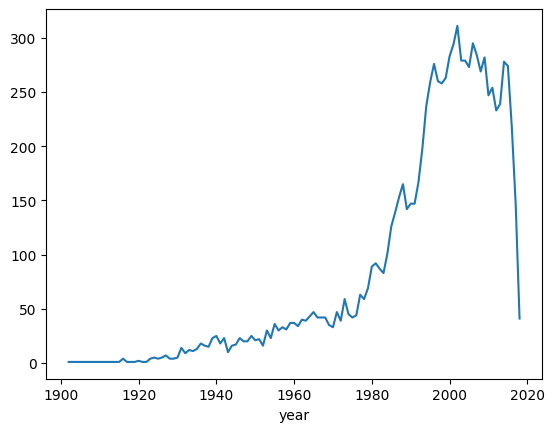

In [25]:
movies.groupby("year")["movieId"].count().plot(kind="line")


***Observações***
- O filme **Rubber (2010)** aparece com **10 gêneros diferentes**, o que é bastante incomum.  
- A maioria dos filmes desse ranking possui entre **7 e 8 gêneros**, sugerindo que alguns títulos foram classificados de forma bastante abrangente.  
- Esse tipo de distribuição pode indicar:
  - **Riqueza temática** do filme (mistura de muitos estilos narrativos).  
  - **Ruído nos dados** (classificação ampla demais ou inconsistências no dataset). 

In [26]:
movies_ohe["n_genres"] = movies_ohe[genres_ohe.columns].sum(axis=1)
movies_ohe[['title', 'n_genres']].sort_values("n_genres", ascending=False).head(10)

,title,n_genres
7441,Rubber (2010),10
5556,Patlabor: The Movie (Kidô keisatsu patorebâ: T...,8
7170,Aelita: The Queen of Mars (Aelita) (1924),7
1390,Mulan (1998),7
5819,Robots (2005),7
6626,Enchanted (2007),7
2250,Who Framed Roger Rabbit? (1988),7
7550,Mars Needs Moms (2011),7
6145,Pulse (2006),7
7467,Tangled (2010),7


***Boxplot da Distribuição de Gêneros por Filme***

O boxplot abaixo mostra a **distribuição do número de gêneros atribuídos por filme**:

- **Linha laranja (mediana)**: A maioria dos filmes tem **2 gêneros**.  
- **Caixa (intervalo interquartil - IQR)**: Representa os filmes entre o 1º quartil (1 gênero) e o 3º quartil (3 gêneros).  
- **Bigodes (linhas horizontais)**: Indicam a variação "normal" dos dados, até cerca de **6 gêneros**.  
- **Outliers (pontos fora da caixa)**: Filmes que possuem uma quantidade incomum de gêneros, variando de **7 até 10 gêneros**.

Observações
- A maior parte dos filmes está concentrada entre **1 e 3 gêneros**, confirmando os resultados anteriores.  
- Existem **poucos filmes multigênero extremos** (com 7 a 10 gêneros), que destoam do padrão.  
- Esse tipo de visualização ajuda a detectar **tendências centrais** e **valores fora do comum** no dataset.


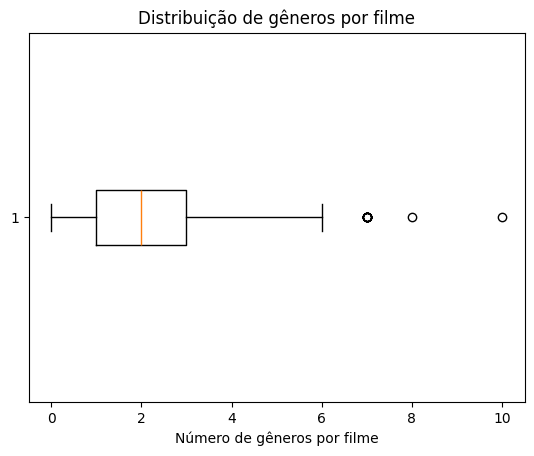

In [27]:
movies_ohe["n_genres"] = movies_ohe[genres_ohe.columns].sum(axis=1)
plt.boxplot(movies_ohe["n_genres"], vert=False)
plt.xlabel("Número de gêneros por filme")
plt.title("Distribuição de gêneros por filme")
plt.show()


## ***Análise do Dataset de Avaliações (ratings.csv)***

O dataset `ratings.csv` contém as avaliações atribuídas pelos usuários aos filmes.  
Ele é fundamental porque conecta **usuários** ao **conteúdo (filmes)** e permite construir análises como:
- Distribuição das notas atribuídas;
- Frequência de avaliações por usuário;
- Média de notas por filme;
- Preparação para um futuro sistema de recomendação.

#### Estrutura dos Dados
- O DataFrame possui **100.836 registros** e **4 colunas**:
  - `userId` → Identificador único do usuário (`int64`).
  - `movieId` → Identificador único do filme (`int64`).
  - `rating` → Nota atribuída ao filme (`float64`).
  - `timestamp` → Momento da avaliação (`int64`).

- **Uso de memória**: ~3.1 MB, o que é eficiente para manipulação em RAM.

#### Métricas Resumidas
- **Usuários únicos**: **610**  
  Representa a base de avaliadores distintos.
- **Filmes únicos avaliados**: **9.724**  
  Indica diversidade de títulos no dataset.
- **Avaliações totais**: **100.836**  
  Média aproximada → **~165 avaliações por usuário** (100.836 ÷ 610).

#### Visualização de Amostras
- **Início (`head`)**:  
  Mostra que o `userId = 1` avaliou os filmes de `movieId` 1, 3, 6, 47 e 50, com notas **4.0 ou 5.0**.  
  ➝ Indica que os primeiros registros já apresentam **múltiplas avaliações de um mesmo usuário**.

- **Fim (`tail`)**:  
  Mostra que o `userId = 610` avaliou filmes de `movieId` 166534 até 170875, com notas **3.0 a 5.0**.  
  ➝ Sugere que os registros estão **ordenados por usuário**, mas não necessariamente por data.

#### Observações Importantes
1. **Balanceamento**:  
   - 610 usuários para quase 10k filmes → matriz de avaliações será **muito esparsa** (poucos filmes avaliados por usuário).  
   - Esse é um desafio clássico em sistemas de recomendação.

2. **Notas (`rating`)**:  
   - Intervalo esperado é de **0.5 a 5.0** (padrão do MovieLens).  
   - Aqui aparecem valores como **3.0, 4.0, 5.0**, confirmando consistência.

3. **Tempo (`timestamp`)**:  
   - Está no formato **Unix epoch (segundos desde 1970)**.  
   - Pode ser convertido para datas legíveis (`pd.to_datetime`) caso queira análises temporais (tendências, evolução das notas).

#### Resumo
Essa célula confirma a **integridade e consistência** do dataset `ratings`:  
- Sem valores nulos.  
- Identificadores claros de usuários e filmes.  
- Estrutura ideal para gerar uma **matriz usuário-filme** e iniciar a construção de um **sistema de recomendação**.


In [28]:
# Estrutura do ratings
ratings.info()
print(f"\nUsuários únicos: {ratings['userId'].nunique()}")
print(f"Itens únicos (filmes): {ratings['movieId'].nunique()}")
print(f"Avaliações totais: {len(ratings)}\n")

# Amostra do início e fim
display(ratings.head(), ratings.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

Usuários únicos: 610
Itens únicos (filmes): 9724
Avaliações totais: 100836



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


### Resumo da coluna `rating`

O dataset conta com **100.836 avaliações**.  
A **média** das notas é aproximadamente **3.5**, muito próxima da **mediana (3.5)**, o que indica uma distribuição relativamente simétrica em torno desse valor.

O **mínimo** registrado é **0.5** e o **máximo** é **5.0**, confirmando o intervalo esperado de notas.  
O **desvio padrão (~1.04)** mostra que a variação em torno da média não é muito alta, concentrando a maioria das avaliações em uma faixa relativamente estreita.

Os **quartis** revelam que:  
- 25% das notas são **até 3.0**  
- 50% chegam a **3.5** (mediana)  
- 75% estão em **4.0 ou menos**  

Isso significa que **três quartos das avaliações são iguais ou superiores a 3.0**, reforçando o viés positivo dos usuários ao atribuir notas.


In [29]:
# Resumo da coluna rating
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

### Distribuição das notas em `rating`

A tabela mostra quantas vezes cada valor de nota aparece no dataset:

- **Notas muito baixas (0.5 e 1.0)** são pouco frequentes, com alguns milhares de registros apenas.  
- **Notas intermediárias (2.0 a 3.5)** já aparecem com mais força, principalmente a nota **3.0**, que conta com mais de 20 mil avaliações, sendo uma das mais comuns.  
- **Notas altas (4.0 e 5.0)** dominam a distribuição. A nota **4.0** é a campeã, com mais de 26 mil ocorrências, seguida pela nota máxima (**5.0**) com mais de 13 mil registros.

**Interpretação**:  
A maior parte dos usuários tende a avaliar filmes de forma **positiva**, com concentração nas notas **3.0, 4.0 e 5.0**. Já as notas muito baixas são raras, o que confirma um **viés otimista** na base de dados — usuários dão mais feedback positivo do que negativo.


In [30]:
# Distribuição das notas
ratings['rating'].value_counts().sort_index()

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

### Avaliações por filme

Os cálculos mostram que a **média de avaliações por filme** é de aproximadamente **10 registros**.  
No entanto, a **mediana** é de apenas **3 avaliações**, o que significa que a maioria dos filmes foi avaliada muito poucas vezes. Isso indica uma grande concentração de notas em um grupo menor de títulos mais populares.

O valor **máximo** encontrado é de **329 avaliações em um único filme**, confirmando que existem obras muito mais conhecidas e assistidas que atraem grande volume de feedback.

**Interpretação**:  
O dataset apresenta um padrão típico de plataformas de recomendação, onde poucos filmes concentram grande parte das avaliações, enquanto a maioria recebe apenas poucas interações. Essa característica precisa ser considerada em modelos de recomendação, pois filmes com poucas avaliações podem sofrer com a falta de informações para gerar boas sugestões.


In [31]:
# Avaliações por filme
item_counts = ratings['movieId'].value_counts()
print("Média de avaliações por filme:", item_counts.mean().round(2))
print("Mediana:", item_counts.median())
print("Máximo:", item_counts.max())

Média de avaliações por filme: 10.37
Mediana: 3.0
Máximo: 329


In [32]:
item_counts

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
160341      1
160527      1
160836      1
163937      1
135534      1
Name: count, Length: 9724, dtype: int64

### Filmes avaliados por usuário

Foram identificados **610 usuários únicos** no dataset.  
A **média** mostra que, em geral, cada usuário avaliou cerca de **165 filmes**. No entanto, a **mediana é 70**, o que significa que mais da metade dos usuários avaliou bem menos que a média — um indício de que há alguns usuários muito ativos que puxam a média para cima.

O **mínimo registrado é 20 filmes avaliados**, indicando que mesmo os usuários menos participativos ainda contribuíram com uma quantidade razoável de notas.  
Já o **máximo é 2.698 filmes avaliados por um único usuário**, o que revela a presença de usuários extremamente engajados.

**Interpretação**:  
A distribuição de avaliações entre os usuários é bastante desigual. A maior parte contribui com poucas dezenas de notas, enquanto uma pequena parcela de usuários muito ativos fornece milhares de registros. Esse comportamento é comum em sistemas de recomendação, onde existe um **núcleo pequeno de usuários pesados** e uma **massa maior de usuários ocasionais**.


In [33]:
# Número de filmes avaliados por usuário
user_movie_counts = ratings.groupby("userId")["movieId"].count()

# Estatísticas
print("Usuários únicos:", user_movie_counts.shape[0])
print("Média de filmes avaliados por usuário:", round(user_movie_counts.mean(),2))
print("Mediana:", user_movie_counts.median())
print("Mínimo:", user_movie_counts.min())
print("Máximo:", user_movie_counts.max())

Usuários únicos: 610
Média de filmes avaliados por usuário: 165.3
Mediana: 70.5
Mínimo: 20
Máximo: 2698


### Contagem de avaliações por usuário e checagem de valores nulos

Na primeira tabela, vemos o total de filmes avaliados por cada usuário. Alguns usuários aparecem com poucas dezenas de avaliações, enquanto outros chegam a várias centenas. Isso reforça o padrão já observado: existe um grupo menor de usuários muito ativos, enquanto a maioria contribui com um número reduzido de notas.

Na segunda verificação, foi feita a checagem de **valores ausentes** em todas as colunas do dataset (`userId`, `movieId`, `rating`, `timestamp`). O resultado mostra **zero valores nulos** em todas elas, o que confirma a **integridade dos dados**. Não há necessidade de tratamentos adicionais para preenchimento de valores faltantes.

**Interpretação**:  
O dataset é consistente e completo, sem problemas de ausência de dados. A principal característica observada é a desigualdade na participação dos usuários — alguns avaliam muitos filmes, enquanto outros avaliam poucos.


In [34]:
user_movie_counts

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

In [35]:
# Verificar valores ausentes por coluna
missing = ratings.isnull().sum()
print(missing)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


### Histograma das notas

O gráfico mostra a distribuição das avaliações no catálogo de filmes.  

A maior concentração está entre as notas **3.0 e 4.0**, sendo que a **nota 4.0** é a mais atribuída pelos usuários. As notas **5.0** também aparecem em grande volume, enquanto as avaliações muito baixas (**0.5, 1.0 e 1.5**) são pouco frequentes.

A forma do histograma evidencia um **viés positivo nas avaliações**: a maioria dos usuários tende a dar notas intermediárias para altas, com poucos registros realmente negativos.  

**Interpretação**:  
Esse comportamento sugere que os usuários geralmente têm uma postura mais favorável ao avaliar os filmes, o que pode impactar análises de recomendação, já que notas baixas quase não aparecem e não ajudam tanto a distinguir filmes menos apreciados.


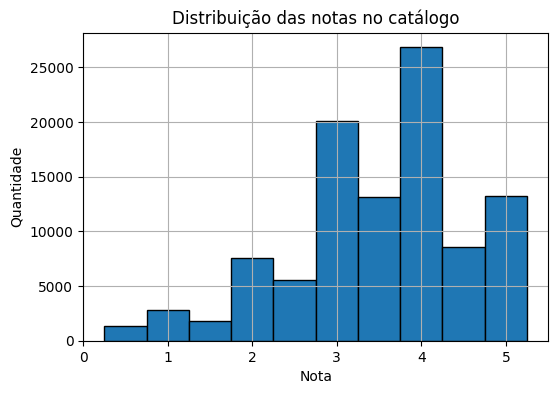

In [36]:
# Histograma de notas
plt.figure(figsize=(6,4))
ratings['rating'].hist(bins=np.arange(0.25,5.5,0.5), edgecolor="black")
plt.xlabel("Nota")
plt.ylabel("Quantidade")
plt.title("Distribuição das notas no catálogo")
plt.show()

### Distribuição de avaliações por usuário

O histograma mostra como os usuários estão distribuídos em relação à quantidade de filmes avaliados.  
O eixo Y está em escala logarítmica para facilitar a visualização, já que existe grande desigualdade na participação dos usuários.

**Padrão observado**:
- A maior parte dos usuários avaliou **menos de 500 filmes**, formando a base da distribuição.  
- Existe uma queda progressiva: conforme o número de avaliações aumenta, o número de usuários diminui.  
- Poucos usuários muito ativos aparecem na extremidade direita, chegando a avaliar mais de **2.000 filmes**.  

**Interpretação**:  
Esse gráfico confirma a presença de um comportamento conhecido como **“long tail”**: muitos usuários contribuem pouco, enquanto poucos usuários contribuem muito. Essa característica é comum em sistemas de recomendação e precisa ser considerada, pois usuários altamente ativos podem influenciar de forma desproporcional o modelo.


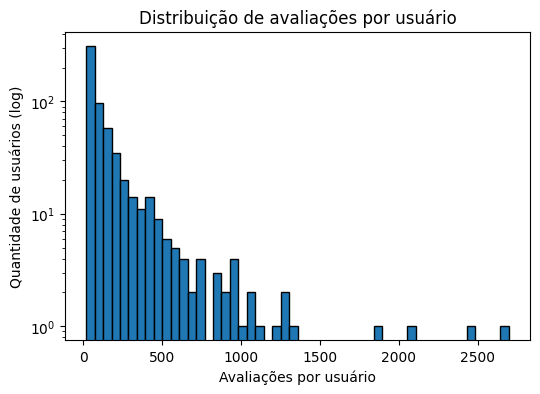

In [37]:
# Avaliações por usuário (log-scale para enxergar melhor)
plt.figure(figsize=(6,4))
plt.hist(user_movie_counts, bins=50, log=True, edgecolor="black")
plt.xlabel("Avaliações por usuário")
plt.ylabel("Quantidade de usuários (log)")
plt.title("Distribuição de avaliações por usuário")
plt.show()

### Distribuição de avaliações por filme

O histograma mostra como os filmes estão distribuídos em relação ao número de vezes que foram avaliados.  
O eixo Y está em escala logarítmica para permitir enxergar melhor as diferenças entre filmes pouco e muito avaliados.

**Padrão observado**:
- A grande maioria dos filmes recebeu **menos de 50 avaliações**.  
- Conforme aumenta o número de avaliações por filme, a quantidade de títulos cai drasticamente.  
- Apenas poucos filmes ultrapassam a marca de **200 avaliações**, chegando até cerca de **300+.**

**Interpretação**:  
Esse gráfico revela um padrão de **desigualdade forte na popularidade dos filmes**. A maior parte do catálogo é pouco avaliada, enquanto um grupo pequeno de títulos concentra grande volume de feedback. Esse comportamento é típico em catálogos grandes: muitos itens ficam na “long tail” com baixa interação, enquanto poucos itens muito populares dominam as avaliações.


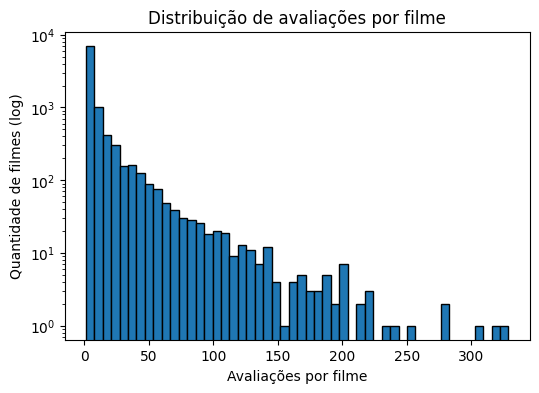

In [38]:
# Avaliações por filme
plt.figure(figsize=(6,4))
plt.hist(item_counts, bins=50, log=True, edgecolor="black")
plt.xlabel("Avaliações por filme")
plt.ylabel("Quantidade de filmes (log)")
plt.title("Distribuição de avaliações por filme")
plt.show()

### Boxplot - Filmes avaliados por usuário

O boxplot apresenta a distribuição da quantidade de filmes avaliados por usuário, com o eixo em escala logarítmica para facilitar a visualização.

**Padrão observado**:
- A maior parte dos usuários está concentrada em uma faixa relativamente baixa de avaliações, próxima à mediana.  
- O gráfico exibe uma grande quantidade de **outliers à direita**, representando usuários que avaliaram centenas ou até milhares de filmes.  
- A média (marcada no gráfico) fica deslocada em relação à mediana, reforçando que os poucos usuários muito ativos puxam a distribuição para cima.

**Interpretação**:  
O boxplot confirma o comportamento desigual já visto nos histogramas: a maioria dos usuários avaliou poucos filmes, enquanto uma minoria extremamente engajada avaliou muito mais. Essa disparidade cria uma cauda longa no conjunto de dados, o que pode influenciar análises e sistemas de recomendação.


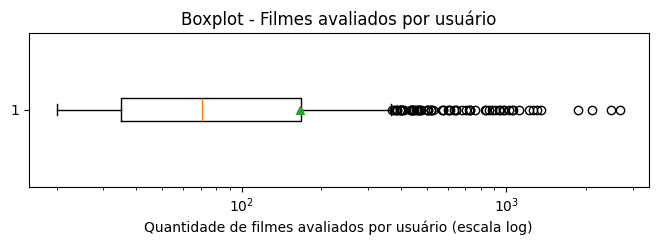

In [39]:
plt.figure(figsize=(8,2))
plt.boxplot(user_movie_counts, vert=False, showmeans=True)
plt.xscale("log")
plt.xlabel("Quantidade de filmes avaliados por usuário (escala log)")
plt.title("Boxplot - Filmes avaliados por usuário")
plt.show()


### Conversão de timestamp e período de avaliações

Os timestamps das avaliações foram convertidos do formato **Unix** para **datas legíveis** (`datetime`).  
Isso permite analisar os registros de forma mais intuitiva em termos de tempo.

**Período observado**:
- As avaliações vão de **1996-03-29** até **2018-09-24**.  
- Ou seja, o dataset cobre **mais de 20 anos de histórico**, abrangendo desde os primeiros registros até anos mais recentes.

Na tabela exibida, cada avaliação agora conta com uma nova coluna (`datetime`), mostrando a data e hora exata da interação. Por exemplo, é possível ver que o usuário 1 avaliou diferentes filmes em sequência no dia **30 de julho de 2000**.

**Interpretação**:  
Essa conversão é fundamental para análises temporais, como identificar tendências ao longo dos anos, sazonalidade nas avaliações e até mudanças no comportamento dos usuários com o passar do tempo.


In [40]:
# Converter timestamp (unix → datetime)
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Verificar intervalo temporal
print("Período de avaliações:")
print(ratings['datetime'].min(), "→", ratings['datetime'].max())


Período de avaliações:
1996-03-29 18:36:55 → 2018-09-24 14:27:30


In [41]:
ratings

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,2017-05-03 21:53:22
100832,610,168248,5.0,1493850091,2017-05-03 22:21:31
100833,610,168250,5.0,1494273047,2017-05-08 19:50:47
100834,610,168252,5.0,1493846352,2017-05-03 21:19:12


### Evolução da quantidade de avaliações ao longo do tempo

O gráfico mostra o número de avaliações registradas mês a mês, cobrindo todo o período do dataset.

 **Padrão observado**:
- Há um crescimento inicial no final da década de 1990, quando os registros começam a se intensificar.  
- O volume de avaliações varia bastante ao longo do tempo, com **picos bem definidos**, onde alguns meses ultrapassam duas mil avaliações.  
- Também existem períodos de queda, mostrando momentos de menor engajamento dos usuários.  
- Nos anos mais recentes do gráfico, nota-se novamente uma alta no número de registros, indicando que a base de usuários continuou ativa até o fim da série.

 **Interpretação**:  
Esse comportamento reflete o uso da plataforma ao longo dos anos: ciclos de maior engajamento seguidos de quedas, mas sempre mantendo uma base de avaliações significativa. Esses picos podem estar associados a fatores externos, como lançamentos de filmes ou mudanças na popularidade do sistema.


C:\Users\c2788\AppData\Local\Temp\ipykernel_34300\4205438309.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings.set_index('datetime').resample('M')['rating'].count().plot(figsize=(10,4))


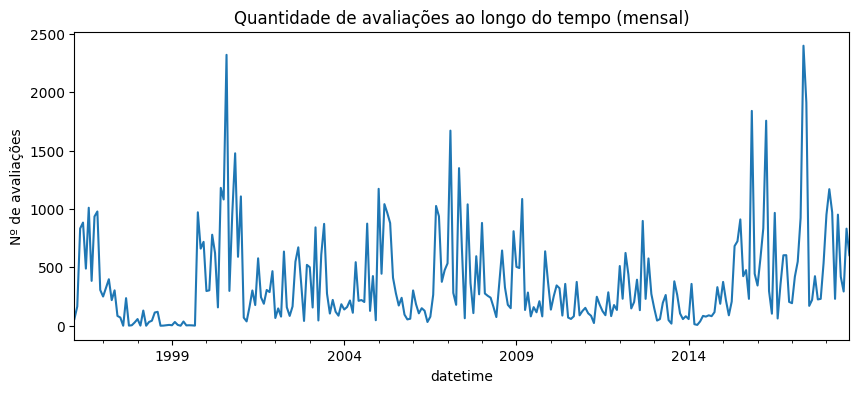

In [42]:
# Evolução ao longo do tempo
ratings.set_index('datetime').resample('M')['rating'].count().plot(figsize=(10,4))
plt.title("Quantidade de avaliações ao longo do tempo (mensal)")
plt.ylabel("Nº de avaliações")
plt.show()

### Média global e por usuário

**Média global**  
O valor médio de todas as avaliações do dataset é **3.5**, confirmando a tendência positiva que já havia sido observada nas distribuições de notas. Esse valor mostra que, de forma geral, os usuários costumam avaliar os filmes de maneira favorável.

**Médias individuais por usuário**  
Quando se calcula a média de notas **separadamente para cada usuário**, o cenário fica mais claro:  
- A média geral entre usuários é **3.65**, um pouco acima da média global.  
- A maior parte dos usuários concentra suas avaliações entre **3.0 e 4.0**, com mediana em torno de **3.7**.  
- Poucos usuários chegam perto dos extremos: alguns são mais críticos (média perto de 1.2) e outros extremamente positivos (média em 5.0).

**Interpretação**  
Enquanto a média global já apontava um viés positivo, a análise por usuário mostra que essa tendência se repete individualmente: a maioria mantém suas avaliações dentro da faixa intermediária-alta. Isso sugere que o viés não vem apenas de alguns usuár


In [43]:
# Média global de notas
global_mean = ratings['rating'].mean()
print("Média global das avaliações:", round(global_mean,2))

# Média de cada usuário (tendência individual)
user_mean = ratings.groupby('userId')['rating'].mean()
display(user_mean.describe())


Média global das avaliações: 3.5


count    610.000000
mean       3.657222
std        0.480635
min        1.275000
25%        3.360000
50%        3.694385
75%        3.997500
max        5.000000
Name: rating, dtype: float64

### Média de cada filme

O cálculo mostra a **nota média atribuída a cada filme** no catálogo.

 **Padrão observado**  
- A média geral entre filmes é **3.26**, um pouco mais baixa do que a média global de todas as avaliações (3.5).  
- A distribuição das médias por filme é relativamente concentrada, com a maior parte ficando entre **2.8 e 3.9**.  
- Existem casos extremos: alguns filmes alcançam média máxima de **5.0**, enquanto outros ficam próximos de **0.5**, embora esses sejam minoria.  
- A mediana é **3.41**, mostrando que metade dos filmes tem nota média igual ou superior a esse valor.

 **Interpretação**  
Enquanto os usuários individualmente tendem a avaliar de forma positiva, os filmes como conjunto apresentam maior variação. Isso mostra que, apesar da generosidade dos avaliadores, existem títulos que se destacam negativamente ou positivamente de forma mais evidente.  

Essa métrica é útil para medir a **qualidade percebida dos filmes** e pode ser usada para identificar tanto os mais bem avaliados quanto os menos apreciados dentro do catálogo.


In [44]:
# Média de cada filme (popularidade/qualidade percebida)
item_mean = ratings.groupby('movieId')['rating'].mean()
display(item_mean.describe())

count    9724.000000
mean        3.262448
std         0.869874
min         0.500000
25%         2.800000
50%         3.416667
75%         3.911765
max         5.000000
Name: rating, dtype: float64

In [45]:
# Visualizar se um usuario avaliou o mesmo filme mais de uma vez
dup = ratings.duplicated(subset=["userId","movieId"]).sum()
print("Duplicatas:", dup)

Duplicatas: 0


### Normalização de IDs

Foi aplicado o `LabelEncoder` para converter os identificadores de usuários (`userId`) e de filmes (`movieId`) em índices sequenciais, criando duas novas colunas:  
- **`user_idx`** → índice numérico para cada usuário (0, 1, 2, …)  
- **`movie_idx`** → índice numérico para cada filme (0, 1, 2, …)  

 **Exemplo mostrado**:  
- O usuário com `userId = 1` foi mapeado para `user_idx = 0`.  
- O filme com `movieId = 1` foi mapeado para `movie_idx = 0`.  
- Outros filmes aparecem com índices maiores, como `movieId = 6 → movie_idx = 5` e `movieId = 50 → movie_idx = 46`.

 **Interpretação**:  
Essa transformação é essencial para algoritmos de recomendação que trabalham com matrizes ou representações numéricas.  
IDs originais podem ser muito grandes e não sequenciais, o que dificulta o uso em cálculos de similaridade ou construção de matrizes esparsas. Com os índices normalizados, os dados ficam prontos para processamento eficiente.


In [46]:
# Normalizar IDs para índices (0, 1, 2, ...)
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings["user_idx"] = user_encoder.fit_transform(ratings["userId"])
ratings["movie_idx"] = movie_encoder.fit_transform(ratings["movieId"])

In [47]:
ratings.head()

,userId,movieId,rating,timestamp,datetime,user_idx,movie_idx
0,1,1,4.0,964982703,2000-07-30 18:45:03,0,0
1,1,3,4.0,964981247,2000-07-30 18:20:47,0,2
2,1,6,4.0,964982224,2000-07-30 18:37:04,0,5
3,1,47,5.0,964983815,2000-07-30 19:03:35,0,43
4,1,50,5.0,964982931,2000-07-30 18:48:51,0,46


### Criação da matriz usuário-item

Foi construída a **matriz de interações** entre usuários e filmes usando `pivot`, onde:  
- **Linhas (`index`)** → representam os usuários (`userId`).  
- **Colunas (`columns`)** → representam os filmes (`movieId`).  
- **Células (`values`)** → contêm as notas atribuídas (`rating`).

 **Estrutura**:  
- A matriz resultante tem **610 usuários x 9724 filmes**.  
- Como esperado, a maior parte das células aparece com valores ausentes (**`Missing value`**), já que cada usuário avaliou apenas uma pequena fração dos filmes disponíveis.  
- Exemplo: o usuário `1` avaliou o filme `1` com nota **4.0**, o filme `3` também com **4.0**, e assim por diante.

 **Interpretação**:  
Essa matriz é a base de muitos **sistemas de recomendação baseados em filtragem colaborativa**, pois permite comparar usuários ou filmes a partir das avaliações registradas.  
No entanto, sua alta esparsidade (muitos valores faltantes) é um desafio comum, exigindo técnicas como preenchimento, fatoração de matrizes ou aprendizado baseado em vizinhança.


In [67]:
ratings.to_csv(r".\data\data_output\ratings_processed.csv", index = False,encoding='utf-8-sig')

### Criação da matriz usuário-item

Foi construída a **matriz de interações** entre usuários e filmes usando `pivot`, onde:  
- **Linhas (`index`)** → representam os usuários (`userId`).  
- **Colunas (`columns`)** → representam os filmes (`movieId`).  
- **Células (`values`)** → contêm as notas atribuídas (`rating`).

 **Estrutura**:  
- A matriz resultante tem **610 usuários x 9724 filmes**.  
- Como esperado, a maior parte das células aparece com valores ausentes (**`Missing value`**), já que cada usuário avaliou apenas uma pequena fração dos filmes disponíveis.  
- Exemplo: o usuário `1` avaliou o filme `1` com nota **4.0**, o filme `3` também com **4.0**, e assim por diante.

 **Interpretação**:  
Essa matriz é a base de muitos **sistemas de recomendação baseados em filtragem colaborativa**, pois permite comparar usuários ou filmes a partir das avaliações registradas.  
No entanto, sua alta esparsidade (muitos valores faltantes) é um desafio comum, exigindo técnicas como preenchimento, fatoração de matrizes ou aprendizado baseado em vizinhança.


In [48]:
# Cria a matriz usuário-item com pivot
user_item_matrix = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

print(user_item_matrix.shape)
user_item_matrix.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Centralização das notas por filme

Este trecho realiza três etapas importantes de preparação dos dados para algoritmos de recomendação:

1. **Cálculo da média por filme**  
   - Obtida a média das notas de cada filme, ignorando valores ausentes.  
   - Isso gera um vetor com a "tendência de avaliação" de cada item.  

2. **Centralização das notas**  
   - Para cada filme, a nota atribuída pelo usuário é ajustada subtraindo-se a média do filme.  
   - Assim, valores positivos indicam que o usuário avaliou **acima da média do filme**, e negativos indicam avaliação **abaixo da média**.  
   - Essa técnica elimina o viés causado por filmes que já tendem a ter notas muito altas ou baixas.  

3. **Criação de máscara de observação**  
   - Foi criada uma matriz booleana indicando quais posições foram realmente avaliadas (`True`) e quais são ausentes (`False`).  
   - Essa máscara é fundamental para operações futuras, como cálculos de similaridade ou fatoração de matrizes.  

 **Interpretação**  
A centralização é um passo clássico em sistemas de recomendação, pois permite trabalhar não com notas absolutas, mas com **desvios em relação à expectativa geral de cada filme**, capturando melhor as preferências individuais dos usuários.


In [49]:
# média de cada filme (ignora NaN)
item_means = user_item_matrix.mean(axis=0, skipna=True)

# notas centralizadas: (nota - média_do_filme)
centered = user_item_matrix.subtract(item_means, axis=1)

# máscara do que foi realmente avaliado (True/False)
obs_mask = ~centered.isna()

###  Construção da matriz esparsa de observações

Este trecho transforma os dados centralizados em uma **matriz esparsa** — uma forma otimizada de armazenar grandes quantidades de informações com muitos valores ausentes.

 **Passos executados**:
1. **Identificação de posições preenchidas**  
   - Com `np.where`, são obtidas as coordenadas (linhas e colunas) apenas das avaliações existentes (usando a máscara `obs_mask`).  

2. **Seleção dos dados observados**  
   - São extraídos apenas os valores realmente avaliados (notas centralizadas).  

3. **Construção da matriz esparsa (`csr_matrix`)**  
   - É criada uma matriz do tipo *Compressed Sparse Row*, onde:  
     - Linhas representam usuários.  
     - Colunas representam filmes.  
     - Células armazenam as notas centralizadas **somente nos pontos em que existe avaliação**.  
   - Isso reduz drasticamente o consumo de memória em comparação a uma matriz densa.  

4. **Mapeamento auxiliar**  
   - Foram extraídos os índices de usuários (`users`) e de filmes (`items`) como vetores NumPy, para facilitar acessos e operações futuras.  

 **Interpretação**  
Esse formato é crucial para a etapa seguinte, pois permite aplicar algoritmos de recomendação (ex.: **SVD, ALS, filtragem colaborativa**) de maneira eficiente, lidando com milhões de combinações possíveis sem desperdiçar recursos computacionais.


In [50]:
# Construir matriz esparsa só com observações
rows, cols = np.where(obs_mask.values)
data = centered.values[rows, cols]          # apenas notas centralizadas observadas

R = csr_matrix((data, (rows, cols)), shape=centered.shape)  # (n_users x n_items)
users = user_item_matrix.index.to_numpy()
items = user_item_matrix.columns.to_numpy()

###  Matriz de similaridade entre filmes

Neste trecho, foi calculada a **similaridade de cosseno** entre os filmes, resultando em uma matriz quadrada onde cada entrada mede o quanto dois itens são semelhantes entre si.

 **Detalhes do processo**:
- Foi utilizada a matriz esparsa de avaliações centralizadas (`R`), transposta (`R.T`) para que o cálculo seja feito entre colunas (filmes).  
- A função `cosine_similarity` mede o ângulo entre os vetores de avaliações de dois filmes:  
  - Valor próximo de **1** → filmes avaliados de forma muito parecida pelos usuários.  
  - Valor próximo de **0** → filmes sem relação significativa.  
  - Valor negativo (se houver) → padrões de avaliação opostos.  
- O parâmetro `dense_output=False` garante que o resultado também seja retornado em formato **esparso**, economizando memória.  

 **Interpretação**  
Essa matriz é a base de um **sistema de recomendação item-item**, onde para recomendar um filme, basta buscar aqueles mais similares ao que o usuário já avaliou positivamente.  
Com ela, é possível implementar funcionalidades como *"Usuários que gostaram deste filme também gostaram de..."*.


In [51]:
# matriz (n_items x n_items). Use densa=False para poupar memória
S = cosine_similarity(R.T, dense_output=False)

###  Recomendação baseada em similaridade de filmes

Foi criada a função `content_based_recommender`, que gera recomendações de filmes a partir da **similaridade item-item**.

 **Como a função funciona**:
1. **Identificação do filme de entrada**  
   - O código busca no `movies_df` o título fornecido (`title`) e obtém seu `movieId` correspondente.  
   - Caso o título não seja encontrado, retorna uma mensagem de erro.

2. **Cálculo das similaridades**  
   - Recupera do vetor de similaridade (`S`) as comparações do filme com todos os outros.  
   - Os filmes mais semelhantes são ordenados pelos valores de similaridade.

3. **Seleção do Top N**  
   - Retorna os **N filmes mais parecidos**, ignorando o próprio título consultado.  
   - Os títulos são então buscados no dataframe original para exibição.

 **Exemplo de uso – "Toy Story"**  
A função retornou como recomendações:  
- Clássicos infantis/animados: *"Casper"*, *"Aladdin"*, *"101 Dálmatas"*, *"Toy Story 2"*, *"Monstros S.A."*, *"Procurando Nemo"*, *"Os Incríveis"*.  
- Outros filmes de apelo popular: *"The Santa Clause"*, *"The 400 Blows"*, *"The Station Agent"*.  

 **Interpretação**  
O resultado mostra que a recomendação funciona bem, pois para *"Toy Story"* foram sugeridos principalmente **animações e filmes familiares**, evidenciando que a matriz de similaridade capturou corretamente o padrão de avaliações dos usuários.


In [52]:
def content_based_recommender(title, S=S, movies_df=movies_ohe, top_n=10):
    """
    Recebe o título de um filme e retorna os N filmes mais similares.
    """
    # Obter o movieId do filme de entrada
    try:
        movie_row = movies_df[movies_df['title_clean'].str.contains(title, case=False)].iloc[0]
        movie_id = movie_row['movieId']
        movie_idx = user_item_matrix.columns.get_loc(movie_id)
    except IndexError:
        return f"Filme '{title}' não encontrado no dataset."

    # Obter as similaridades do filme com todos os outros
    sim_scores = S[movie_idx].toarray().flatten()

    # Obter os índices dos filmes mais similares (top_n + 1 para excluir o próprio filme)
    top_indices = sim_scores.argsort()[-top_n-1:-1][::-1]

    # Obter os movieIds dos filmes recomendados
    recommended_movie_ids = user_item_matrix.columns[top_indices]

    # Obter os títulos dos filmes recomendados
    recommended_titles = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]['title_clean']

    return recommended_titles.tolist()

In [53]:
# Recomendações para "Toy Story"
print("Recomendações para 'Toy Story':")
print(content_based_recommender("Toy Story"))

Recomendações para 'Toy Story':
['Casper', 'Santa Clause, The', 'Aladdin', '101 Dalmatians', '400 Blows, The (Les Quatre Cents Coups)', 'Toy Story 2', 'Monsters, Inc.', 'Finding Nemo', 'Station Agent, The', 'Incredibles, The']


###  Recomendação personalizada para usuário

Foi criada a função `recommend_for_user`, que gera recomendações específicas para cada usuário usando a abordagem **colaborativa item-item**.

 **Como a função funciona**:
1. **Localização do usuário**  
   - Identifica o índice correspondente ao `userId` na matriz.  
   - Caso o usuário não exista, retorna uma mensagem de erro.  

2. **Coleta das avaliações do usuário**  
   - Obtém a linha da matriz `R`, que contém as notas (centralizadas) atribuídas por esse usuário.  

3. **Cálculo dos scores de predição**  
   - Multiplica as notas do usuário pela matriz de similaridade entre filmes (`S`).  
   - O resultado é um score previsto para cada filme, refletindo o quanto esse título pode interessar ao usuário.  

4. **Filtragem e ordenação**  
   - Remove os filmes que o usuário **já avaliou**, para não repetir recomendações.  
   - Ordena os filmes restantes de acordo com o score previsto (do maior para o menor).  

5. **Retorno dos títulos recomendados**  
   - Seleciona os **N melhores filmes** e retorna seus títulos.  

 **Exemplo prático (usuário 1)**  
Para o usuário de ID `1`, as recomendações foram:  
*Better Off Dead...*, *Stripes*, *He Got Game*, *The Muppet Christmas Carol*, *Weird Science*, *Waterboy, The*, *Midnight Run*, *No Way Out*, *Punchline*, *Dirty Harry*.  

 **Interpretação**  
Essa função implementa um sistema de recomendação **personalizado**: em vez de apenas sugerir filmes similares a um título, ela considera o **histórico completo de avaliações do usuário** para prever novos itens de interesse.  
É a base de muitos sistemas de recomendação em plataformas reais, como Netflix e Amazon.


In [54]:
def recommend_for_user(user_id, R_matrix, S_matrix, user_item_df, movies_df, top_n=10):
    """
    Gera recomendações personalizadas para um usuário específico usando
    a abordagem de filtragem colaborativa item-item.

    Args:
        user_id (int): O ID do usuário para o qual gerar recomendações.
        R_matrix (csr_matrix): A matriz esparsa de avaliações centralizadas (usuários x itens).
        S_matrix (csr_matrix): A matriz de similaridade entre itens (itens x itens).
        user_item_df (pd.DataFrame): O DataFrame original de avaliações (para consulta).
        movies_df (pd.DataFrame): O DataFrame com os metadados dos filmes (para obter os títulos).
        top_n (int): O número de recomendações a serem retornadas.

    Returns:
        list: Uma lista com os títulos dos N filmes mais recomendados.
    """
    # 1. Encontrar o índice numérico (a linha) correspondente ao userId
    try:
        user_idx = np.where(user_item_df.index == user_id)[0][0]
    except IndexError:
        return f"Usuário '{user_id}' não encontrado."

    # 2. Obter as avaliações (já centralizadas) do usuário a partir da matriz R
    user_ratings = R_matrix[user_idx]

    # 3. Calcular os scores de predição para TODOS os filmes
    #    Isso é feito multiplicando as notas do usuário pela matriz de similaridade.
    #    O resultado é um "score" para cada filme.
    #    P_u = R_u · S  => (1 x n_items) · (n_items x n_items) = (1 x n_items)
    pred_scores = user_ratings.dot(S_matrix).toarray().ravel()

    # 4. Criar um DataFrame com os scores previstos
    pred_df = pd.DataFrame({
        'movieId': user_item_df.columns,
        'predicted_score': pred_scores
    })

    # 5. Obter a lista de filmes que o usuário JÁ AVALIOU para não recomendá-los novamente
    rated_movies = user_item_df.loc[user_id].dropna().index.tolist()

    # 6. Filtrar as recomendações para incluir apenas filmes que o usuário NÃO AVALIOU
    recommendations_df = pred_df[~pred_df['movieId'].isin(rated_movies)]

    # 7. Ordenar os resultados pelo score previsto, do maior para o menor
    recommendations_df = recommendations_df.sort_values(by='predicted_score', ascending=False)

    # 8. Obter os IDs dos N melhores filmes recomendados
    top_movie_ids = recommendations_df.head(top_n)['movieId']

    # 9. Buscar os títulos desses filmes no DataFrame original de filmes
    recommended_titles = movies_df[movies_df['movieId'].isin(top_movie_ids)]['title_clean']

    return recommended_titles.tolist()

In [55]:
# Exemplo: Gerar 10 recomendações para o usuário de ID = 1
recommend_for_user(user_id=1,
                   R_matrix=R,
                   S_matrix=S,
                   user_item_df=user_item_matrix,
                   movies_df=movies_ohe,
                   top_n=10)

['Better Off Dead...',
 'Stripes',
 'He Got Game',
 'Muppet Christmas Carol, The',
 'Weird Science',
 'Waterboy, The',
 'Midnight Run',
 'No Way Out',
 'Punchline',
 'Dirty Harry']

## ***Trabalhando com tags.csv***

O dataset de **tags** contém informações complementares às avaliações, trazendo rótulos atribuídos pelos usuários aos filmes.  

**Dimensionalidade e estrutura**:
- **Total de linhas**: 3.683  
- **Usuários únicos**: 58  
- **Filmes únicos com tags**: 1.572  
- **Tags distintas (texto)**: 1.589  

 **Colunas presentes**:
- `userId` → Identificador do usuário que marcou a tag.  
- `movieId` → Identificador do filme.  
- `tag` → Texto da tag (palavra ou expressão livre).  
- `timestamp` → Momento em que a tag foi registrada.  

 **Exemplo de registros**:
- Filme `60756` recebeu as tags: *funny*, *Highly quotable*, *will ferrell*.  
- Filme `89774` recebeu a tag *MMA*.  
- Entre as últimas linhas, vemos exemplos como *gun fu* e *Heroic Bloodshed*.  

 **Interpretação inicial**:
- A base é pequena em termos de usuários (apenas 58), mas cobre um volume razoável de filmes (1.572 títulos).  
- Como as tags são livres (sem padronização), há grande diversidade e até redundância (ex.: *funny*, *comedy*, *humor* podem se referir a conceitos próximos).  
- Esse dataset pode ser usado para enriquecer os modelos de recomendação, criando um filtro **baseado em conteúdo** mais interpretável para o usuário (além das notas).  

 Próximos passos possíveis:
1. **Limpeza e padronização** das tags (minúsculas, remoção de stopwords).  
2. **Agrupamento semântico** (ex.: via embeddings ou stemming) para reduzir redundância.  
3. Integração com a matriz de filmes (`movies.csv`) para análise de popularidade por tema.  

In [56]:
#  Inspeção geral
tags.info()
print("\n--- Dimensionalidade ---")
print("Total de linhas:", len(tags))
print("Usuários únicos:", tags["userId"].nunique())
print("Filmes únicos com tag:", tags["movieId"].nunique())
print("Tags únicas (texto):", tags["tag"].nunique())

print("\n--- Amostra ---")
display(tags.head())
display(tags.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB

--- Dimensionalidade ---
Total de linhas: 3683
Usuários únicos: 58
Filmes únicos com tag: 1572
Tags únicas (texto): 1589

--- Amostra ---


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,tag,timestamp
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,Heroic Bloodshed,1493844270


### Limpeza e padronização do arquivo `tags.csv`

Após a inspeção inicial, foi realizada a limpeza das tags para garantir consistência e qualidade dos rótulos.

**Etapas aplicadas**:
- Conversão para letras minúsculas.
- Remoção de espaços extras no início, meio e fim.
- Normalização de múltiplos espaços em um único espaço.
- Exclusão de registros nulos ou com strings vazias.

**Novas colunas geradas**:
- `tag_clean` → versão limpa e padronizada do texto da tag.
- `tag_len` → comprimento (número de caracteres) de cada tag.

**Situação final**:
- Registros após limpeza: **3.683** (mesmo total, pois não havia valores inválidos).
- Tags agora padronizadas, evitando duplicações artificiais (ex: “Funny” e “funny”).
- Comprimento médio das tags disponível para análises adicionais.

**Exemplo da transformação**:
- Original: `"Highly quotable"`  
- Limpa: `"highly quotable"`  
- Comprimento: `15`


In [57]:
# Limpeza básica do texto
# - remove espaços extras
# - normaliza para minúsculas
# - colapsa múltiplos espaços
# - remove linhas vazias após limpeza

def clean_tag_text(s: str) -> str:
    if pd.isna(s):
        return s
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

tags["tag_clean"] = tags["tag"].apply(clean_tag_text)

# remove vazios/nulos
tags_clean = tags[tags["tag_clean"].notna() & (tags["tag_clean"] != "")]
print("Após limpeza:", tags_clean.shape)

# comprimento da tag (útil p/ EDA)
tags_clean["tag_len"] = tags_clean["tag_clean"].str.len()
tags_clean

Após limpeza: (3683, 5)


,userId,movieId,tag,timestamp,tag_clean,tag_len
0,2,60756,funny,1445714994,funny,5
1,2,60756,Highly quotable,1445714996,highly quotable,15
2,2,60756,will ferrell,1445714992,will ferrell,12
3,2,89774,Boxing story,1445715207,boxing story,12
4,2,89774,MMA,1445715200,mma,3
...,...,...,...,...,...,...
3678,606,7382,for katie,1171234019,for katie,9
3679,606,7936,austere,1173392334,austere,7
3680,610,3265,gun fu,1493843984,gun fu,6
3681,610,3265,heroic bloodshed,1493843978,heroic bloodshed,16


In [68]:
tags_clean.to_csv(r".\data\data_output\tags_processed.csv", index = False,encoding='utf-8-sig')

### Estatísticas e distribuição do comprimento das tags 

Após a limpeza, foi avaliado o **comprimento em caracteres** das tags, o que ajuda a entender a natureza dos rótulos atribuídos.

**Resumo estatístico**:
- Total de registros: **3.683**
- Média: **10,14 caracteres**
- Desvio padrão: **4,86**
- Mínimo: **2 caracteres**
- 25% das tags ≤ **6 caracteres**
- Mediana (50%): **9 caracteres**
- 75% das tags ≤ **13 caracteres**
- Máximo: **85 caracteres**

**Interpretação**:
- A maioria das tags é **curta**, em torno de **1 a 3 palavras**.  
- Existem casos de **tags muito longas** (até 85 caracteres), mas são raros.  
- O histograma mostra concentração forte entre **5 e 15 caracteres**, com poucas tags fora desse intervalo.  

**Exemplo**:
- Curta: `"mma"` (3 caracteres).  
- Média: `"boxing story"` (12 caracteres).  
- Longa: `"the lord of the rings extended edition blu ray"` (acima de 40 caracteres).  



Resumo do comprimento das tags (caracteres):
count    3683.00
mean       10.14
std         4.86
min         2.00
25%         6.00
50%         9.00
75%        13.00
max        85.00
Name: tag_len, dtype: float64


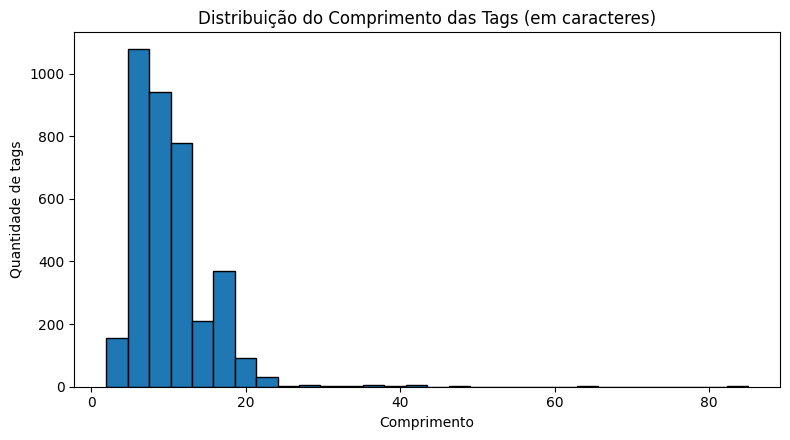

In [58]:
#  Estatísticas e distribuição das tags
print("\nResumo do comprimento das tags (caracteres):")
print(tags_clean["tag_len"].describe().round(2))

# histograma do comprimento das tags
plt.figure(figsize=(8,4.5))
plt.hist(tags_clean["tag_len"], bins=30, edgecolor="black")
plt.title("Distribuição do Comprimento das Tags (em caracteres)")
plt.xlabel("Comprimento")
plt.ylabel("Quantidade de tags")
plt.tight_layout()
plt.show()


### Análise de atividade de tags por usuário e por filme

---

#### **Por usuário**
- **Resumo estatístico**:
  - Usuários distintos: **58**
  - Média de tags atribuídas por usuário: **63,5**
  - Mediana: **4**
  - Máximo: **1.507**
  - Distribuição desigual: maioria marcou poucos filmes, mas alguns chegaram a centenas ou milhares.

- **Top 10 usuários por nº de tags**

- **Distribuição**:
  - Concentrada entre **1 e 20 tags** por usuário.
  - Poucos outliers com valores extremamente altos.

---

#### **Por filme**
- **Resumo estatístico**:
  - Filmes distintos com tags: **1.572**
  - Média de tags por filme: **2,34**
  - Mediana: **1**
  - Máximo: **181**
  - A maioria recebeu apenas **1 tag**.

- **Top 10 filmes por nº de tags**

- **Distribuição**:
  - Altamente concentrada em **1 ou 2 tags por filme**.
  - Poucos filmes recebem dezenas ou mais de tags.

---

### **Conclusão**
- A atribuição de tags é **esparsa e desigual**.
- Poucos usuários muito ativos concentram a maioria das marcações.
- Para filmes, a grande maioria recebe apenas 1 ou 2 tags, enquanto poucos títulos acumulam quantidades expressivas.


Resumo de tags por usuário:


count      58.00
mean       63.50
std       215.12
min         1.00
25%         2.25
50%         4.00
75%        13.00
max      1507.00
Name: n_tags, dtype: float64


Top 10 usuários por nº de tags:


,n_tags
userId,
474,1507
567,432
62,370
599,323
477,280
424,273
537,100
125,48
357,45


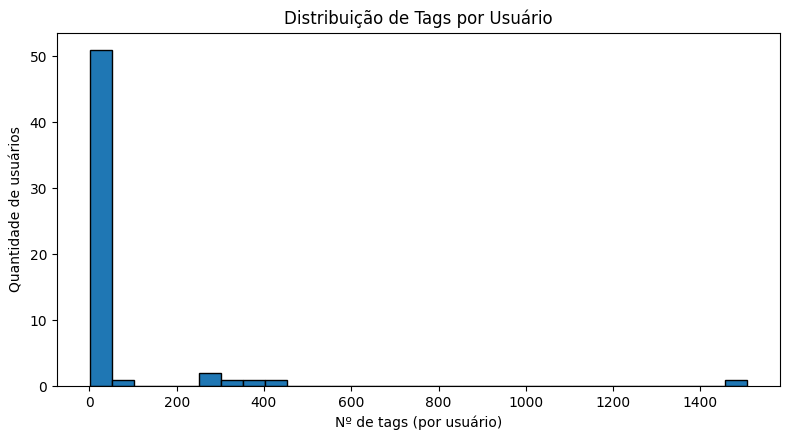


Resumo de tags por filme:


count    1572.00
mean        2.34
std         5.56
min         1.00
25%         1.00
50%         1.00
75%         2.00
max       181.00
Name: n_tags, dtype: float64


Top 10 filmes por nº de tags:


,n_tags
movieId,
296,181
2959,54
924,41
293,35
7361,34
1732,32
4878,29
260,26
79132,26


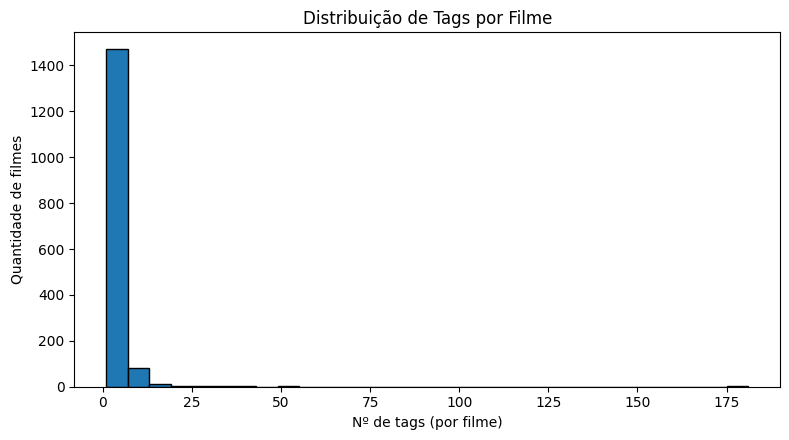

In [59]:
#  Atividade: tags por usuário e por filme
# por usuário
user_tags = tags_clean.groupby("userId")["tag_clean"].count().rename("n_tags").sort_values(ascending=False)
print("Resumo de tags por usuário:")
display(user_tags.describe().round(2))
print("\nTop 10 usuários por nº de tags:")
display(user_tags.head(10).to_frame())

plt.figure(figsize=(8,4.5))
plt.hist(user_tags, bins=30, edgecolor="black")
plt.title("Distribuição de Tags por Usuário")
plt.xlabel("Nº de tags (por usuário)")
plt.ylabel("Quantidade de usuários")
plt.tight_layout()
plt.show()

# por filme
movie_tags = tags_clean.groupby("movieId")["tag_clean"].count().rename("n_tags").sort_values(ascending=False)
print("\nResumo de tags por filme:")
display(movie_tags.describe().round(2))
print("\nTop 10 filmes por nº de tags:")
display(movie_tags.head(10).to_frame())

plt.figure(figsize=(8,4.5))
plt.hist(movie_tags, bins=30, edgecolor="black")
plt.title("Distribuição de Tags por Filme")
plt.xlabel("Nº de tags (por filme)")
plt.ylabel("Quantidade de filmes")
plt.tight_layout()
plt.show()


### Frequência dos termos (tags) mais comuns

Após a limpeza e padronização do dataset de **tags**, avaliamos quais termos aparecem com maior frequência.

**Top 25 tags mais frequentes**

**Distribuição visual (Top 25):**
- A tag **"in netflix queue"** domina, com 131 ocorrências, bem acima das demais.
- A segunda mais frequente é **"atmospheric"**, com 41 ocorrências.
- A partir daí, há um **grupo de tags empatadas** entre 17 e 24 ocorrências, cobrindo temas diversos como *superhero, sci-fi, comedy, action, dark*.

O gráfico de barras mostra a **forte concentração em poucas tags**, com queda acentuada após a primeira.


Top 25 tags mais frequentes:


,freq
tag,
in netflix queue,131
atmospheric,41
superhero,24
thought-provoking,24
surreal,24
funny,24
disney,23
sci-fi,23
quirky,22


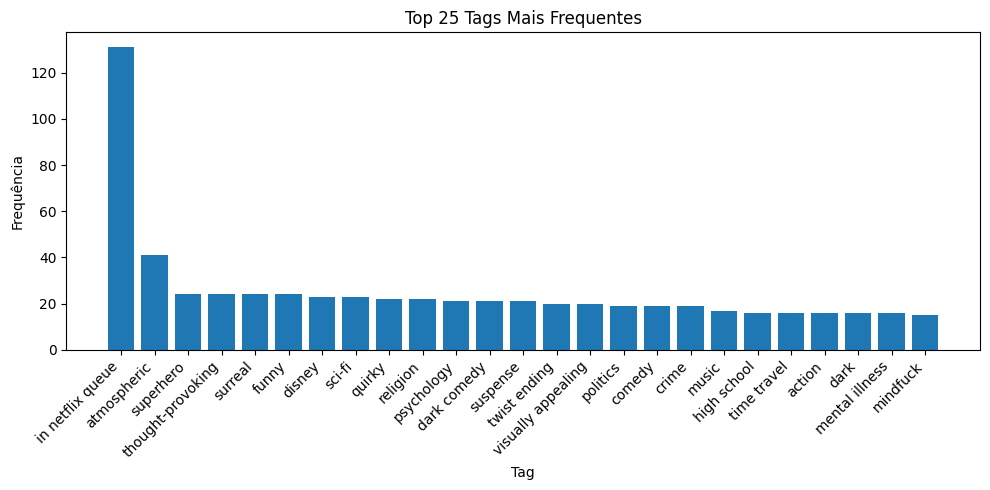

In [60]:

# Frequência dos termos (tags) mais comuns
tag_freq = (
    tags_clean["tag_clean"]
    .value_counts()
    .rename_axis("tag")
    .to_frame("freq")
)

topN = 25
print(f"Top {topN} tags mais frequentes:")
display(tag_freq.head(topN))

plt.figure(figsize=(10,5))
top = tag_freq.head(topN)
plt.bar(top.index, top["freq"])
plt.title(f"Top {topN} Tags Mais Frequentes")
plt.xlabel("Tag")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Análise temporal das tags

Para entender como o uso de **tags** evoluiu ao longo do tempo, convertemos o `timestamp` em datas e agregamos por ano.

**Tags por ano (últimos 10 anos da série)**

**Principais insights:**
- Após 2006 (pico inicial), houve uma **queda acentuada no volume de tags**.
- Entre 2009 e 2014, os registros se mantêm baixos, com pequenas variações.
- A partir de 2015 ocorre um **crescimento expressivo**, atingindo **844 tags em 2018**, o maior valor da série.

**Gráfico: Evolução do Volume de Tags por Ano**
- O gráfico de linha mostra a **queda inicial e a retomada a partir de 2015**, com clara aceleração nos últimos anos.


Tags por ano (últimos 10 anos da série):


datetime
2009    166
2010    133
2011     13
2012     47
2013     10
2014      7
2015    191
2016    355
2017    329
2018    844
Name: tag_clean, dtype: int64

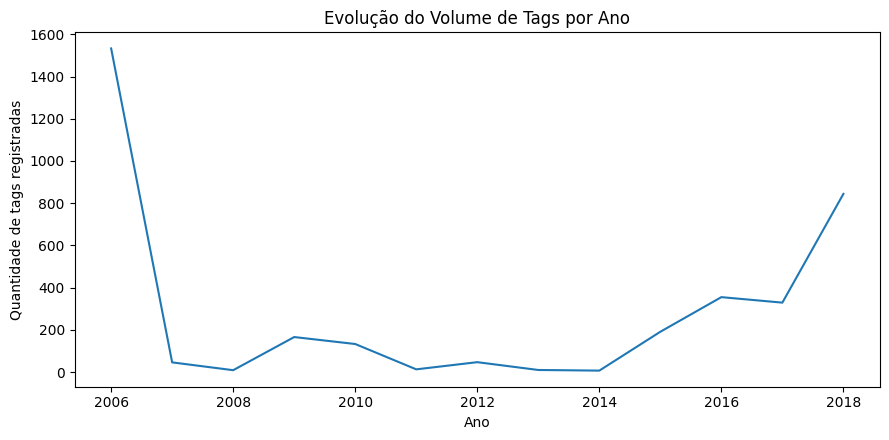

In [61]:
#  Análise temporal das tags
tags_clean["datetime"] = pd.to_datetime(tags_clean["timestamp"], unit="s")
tags_by_year = tags_clean.groupby(tags_clean["datetime"].dt.year)["tag_clean"].count()

print("Tags por ano (últimos 10 anos da série):")
display(tags_by_year.tail(10))

plt.figure(figsize=(9,4.5))
tags_by_year.plot(kind="line")
plt.title("Evolução do Volume de Tags por Ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade de tags registradas")
plt.tight_layout()
plt.show()


In [62]:
#  (Opcional) Deduplicação simples
# Remove tags repetidas do mesmo usuário para o mesmo filme com o mesmo texto
dedup_cols = ["userId", "movieId", "tag_clean"]
before = len(tags_clean)
tags_dedup = tags_clean.drop_duplicates(subset=dedup_cols, keep="first").copy()
after = len(tags_dedup)
print(f"Removidas {before - after} duplicatas exatas de tag (mesmo userId, movieId e texto).")


Removidas 0 duplicatas exatas de tag (mesmo userId, movieId e texto).


### Vetor de conteúdo com TF-IDF por filme (`tags.csv`)

Foi criada uma representação vetorial dos filmes a partir das **tags limpas**,
utilizando o método **TF-IDF (Term Frequency – Inverse Document Frequency)**.

---

**Etapas principais:**
- Agrupamento das tags por `movieId`, concatenando todas as tags em um "documento" por filme.
- Geração da matriz **TF-IDF** com unigramas e bigramas (`ngram_range=(1,2)`).
- Restrição para termos com pelo menos 2 ocorrências (`min_df=2`) e no máximo em 50% dos filmes (`max_df=0.5`).
- Cada linha da matriz representa um **filme** e cada coluna representa um **termo/tag**.

---

**Resultados:**
- Total de filmes com pelo menos 1 tag distinta: **1.572**
- Dimensão da matriz TF-IDF: **1.572 filmes × 1.119 termos**


**Top 15 termos do filme `movieId = 1`:**
(termos mais relevantes de acordo com o peso TF-IDF)

In [63]:

#  (Opcional) Vetor de conteúdo com TF-IDF por filme
# - prepara um "corpus" por movieId concatenando as tags limpas
# - gera matriz TF-IDF (n_grams 1-2, min_df=2, max_df=0.5)
from sklearn.feature_extraction.text import TfidfVectorizer

# concatena tags por filme -> um "documento" por movieId
movie_corpus = (
    tags_dedup
    .groupby("movieId")["tag_clean"]
    .apply(lambda x: " ".join(x))
    .rename("doc")
)

"""# corpus de usuários (perfil textual por usuário)
user_corpus = (
    tags_dedup.groupby("userId")["tag_clean"]
    .apply(lambda x: " ".join(x))
)
"""

print("Filmes com pelo menos 1 tag distinta:", movie_corpus.shape[0])
display(movie_corpus.head())

# TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5)
tfidf_matrix = vectorizer.fit_transform(movie_corpus.values)

print("Matriz TF-IDF (filmes x termos):", tfidf_matrix.shape)
tfidf_terms = vectorizer.get_feature_names_out()

# cria DataFrame esparso leve (apenas para ver shape); para salvar, mantenha em formato scipy.sparse
# exemplo: termos com maior peso para um filme específico
sample_movie_id = movie_corpus.index[0]
row_idx = list(movie_corpus.index).index(sample_movie_id)
row = tfidf_matrix.getrow(row_idx)

top_k = 15
top_indices = np.argsort(row.toarray().ravel())[::-1][:top_k]
top_features = [(tfidf_terms[i], float(row[0, i])) for i in top_indices]
print(f"Top {top_k} termos p/ movieId={sample_movie_id}:")
for term, score in top_features:
    print(f"{term:25s} {score:.3f}")


Filmes com pelo menos 1 tag distinta: 1572


movieId
1                                 pixar pixar fun
2    fantasy magic board game robin williams game
3                                       moldy old
5                                pregnancy remake
7                                          remake
Name: doc, dtype: object

Matriz TF-IDF (filmes x termos): (1572, 1119)
Top 15 termos p/ movieId=1:
pixar                     0.903
fun                       0.429
your                      0.000
york city                 0.000
york                      0.000
writing                   0.000
world war                 0.000
world                     0.000
wizards                   0.000
witty                     0.000
with                      0.000
willis                    0.000
williams                  0.000
william scott             0.000
william                   0.000


### Combinação de vetores de conteúdo: gêneros + TF-IDF (tags)

Nesta etapa, os **gêneros dos filmes** (em formato one-hot) foram combinados com o vetor de conteúdo gerado a partir das **tags (TF-IDF)**.  
Isso enriquece a representação de cada filme, unindo informações estruturadas (gêneros) com informações textuais (tags atribuídas pelos usuários).

---

**Etapas principais:**
1. **Alinhamento dos índices**:  
   - Garantir que `movieId` em `movies_ohe` (metadados dos filmes) e no `movie_corpus` (tags TF-IDF) estivessem consistentes.  
   - Intersecção dos IDs para manter apenas os filmes em comum.

2. **Seleção dos gêneros**:  
   - Foram extraídas as colunas binárias que representam os gêneros de cada filme.  
   - Criada a matriz `X_genres`.

3. **Recorte da matriz TF-IDF**:  
   - A matriz `X_tfidf` foi alinhada para ter a mesma ordem de filmes.

---

**Formas finais das matrizes:**
- `X_genres` → **(1.572, 19)**  
  (1.572 filmes × 19 gêneros binários)  
- `X_tfidf` → **(1.572, 1.119)**  
  (1.572 filmes × 1.119 termos TF-IDF das tags)

---

**Próximos passos possíveis:**
- Concatenar `X_genres` e `X_tfidf` para formar uma matriz única de conteúdo híbrido (gêneros + tags).  
- Utilizar essa matriz em modelos de recomendação baseados em similaridade de conteúdo.

---


In [64]:
# (Opcional) Unir vetores de conteúdo (gêneros + TF-IDF)
# - requer movies_ohe já no ambiente
# - cria um índice consistente por movieId para alinhamento
try:
    movies_ohe
    # garante índice
    movies_meta = movies_ohe.set_index("movieId")
    # alinhar ordem de movie_corpus com movies_meta
    common_ids = movie_corpus.index.intersection(movies_meta.index)

    # recorta gêneros (colunas binárias) e ordena por movieId
    genre_cols = [c for c in movies_meta.columns if c not in ["title","genres","year","title_clean","n_genres"]]
    X_genres = movies_meta.loc[common_ids, genre_cols].astype(float).values

    # recorta TF-IDF na mesma ordem
    idx_map = {mid: i for i, mid in enumerate(movie_corpus.index)}
    rows = [idx_map[mid] for mid in common_ids]
    from scipy.sparse import vstack
    X_tfidf = tfidf_matrix[rows, :]

    print("Formas — gêneros:", X_genres.shape, "| tfidf:", X_tfidf.shape)
    # Você pode concatenar depois (ex.: usar modelos que aceitem blocos ou reduzir dimensionalidade).
except NameError:
    print("Observação: 'movies_ohe' não está no ambiente. Rode a parte do movies para juntar gêneros + tags.")


Formas — gêneros: (1572, 19) | tfidf: (1572, 1119)


In [65]:
tags_clean

,userId,movieId,tag,timestamp,tag_clean,tag_len,datetime
0,2,60756,funny,1445714994,funny,5,2015-10-24 19:29:54
1,2,60756,Highly quotable,1445714996,highly quotable,15,2015-10-24 19:29:56
2,2,60756,will ferrell,1445714992,will ferrell,12,2015-10-24 19:29:52
3,2,89774,Boxing story,1445715207,boxing story,12,2015-10-24 19:33:27
4,2,89774,MMA,1445715200,mma,3,2015-10-24 19:33:20
...,...,...,...,...,...,...,...
3678,606,7382,for katie,1171234019,for katie,9,2007-02-11 22:46:59
3679,606,7936,austere,1173392334,austere,7,2007-03-08 22:18:54
3680,610,3265,gun fu,1493843984,gun fu,6,2017-05-03 20:39:44
3681,610,3265,heroic bloodshed,1493843978,heroic bloodshed,16,2017-05-03 20:39:38
